In [2]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, get_file
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

In [3]:
# for loading the captions file
def load_doc(filename):
    file =open(filename, 'r')
    text = file.read()
    file.close()
    return text

# for loading the images
def all_img_captions(filename):
    file = load_doc(filename) # load the captions file
    captions = file.split('\n') # split the file into lines
    descriptions = {} # create an empty dictionary to store image names and their captions
    for caption in captions[:-1]:
        img,caption = caption.split('\t') # split each line into image name and caption
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption] # if the image is not already in the dictionary, create a new list
        else:
            descriptions[img[:-2]].append(caption) # if the image is already in the dictionary, append the caption to the list
    return descriptions

# for cleaning the text data
def cleaning_text(captions):  
    table = str.maketrans('', '', string.punctuation) # create a translation table to remove punctuation
    for img, caps in captions.items():
        for i,img_caption in enumerate(caps): 
            img_caption.replace("-", "  ") # replace hyphens with spaces
            desc = img_caption.split() # split the caption into words
            desc = [word.lower() for word in desc] # convert all words to lowercase
            desc = [word.translate(table) for word in desc] # remove punctuation from words
            desc = [word for word in desc if len(word)>1] # remove words with length less than 2
            desc = [word for word in desc if word.isalpha()] # remove words that are not alphabetic

            img_caption = ' '.join(desc) # join the words back into a caption
            captions[img][i] = img_caption 
    return captions

def text_vocabulary(descriptions): 
    vocab = set() # create an empty set to store unique words
    for key in descriptions.keys(): 
        [vocab.update(d.split()) for d in descriptions[key]] # for each image, split the captions into words and add them to the vocabulary set
    return vocab

def save_descriptions(descriptions, filename): 
    lines = list()  # create an empty list to store the lines to be written to the file
    for key, desc_list in descriptions.items(): 
        for desc in desc_list:
            lines.append(key + '\t' + desc) # for each image, append the image name and caption to the lines list
    data = '\n'.join(lines) # join the lines into a single string with newline characters
    file = open(filename, 'w') # open the file in write mode
    file.write(data) # write the data to the file
    file.close() # close the file
    print('Saved descriptions to', filename) 

In [ ]:
dataset_text = "E:\My_Folder\Local_Repository\Machine Learning\Image Caption youtube\Flickr8k_text"
dataset_images = "E:\My_Folder\Local_Repository\Machine Learning\Image Caption youtube\Flicker8k_Dataset"

filename = dataset_text + '/Flickr8k.token.txt'

descriptions = all_img_captions(filename)
print('Loaded descriptions:', len(descriptions))

cleaned_descriptions = cleaning_text(descriptions)

vocabulary = text_vocabulary(cleaned_descriptions)
print('Vocabulary Size:', len(vocabulary))

save_descriptions(cleaned_descriptions, dataset_text + '/descriptions.txt')

In [ ]:
# print the first 10 words in the vocabulary
print(list(vocabulary)[:10])

# description 
print('Sample descriptions:', list(descriptions.items())[:10])

# cleaned descriptions
print('Sample cleaned descriptions:', list(cleaned_descriptions.items())[:10])

In [ ]:
def download_with_retry(url, filename, max_retries=3):
    for attempt in range(max_retries):
        try:
            return get_file(filename, url)
        except Exception as e:
            if attempt == max_retries - 1:
                raise e
            print(f"Download attempt {attempt + 1} failed. Retrying in 5 seconds...")
            time.sleep(5)

# Replace the Xception model initialization with:
weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_path = download_with_retry(weights_url, 'xception_weights.h5')
model = Xception(include_top=False, pooling='avg', weights=weights_path)

In [ ]:
def extract_features(directory):
    features = {}
    valid_images = ['.jpg', '.jpeg', '.png']  # Add other formats if needed
    
    for img in tqdm(os.listdir(directory)):
        ext = os.path.splitext(img)[1].lower() # Get the file extension and convert it to lowercase
        if ext not in valid_images: # Skip files that don't end with valid image extensions
            continue
            
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0) # add a new axis to the image to match the input shape of the model
        image = image/127.5 # normalize the image
        image = image - 1.0 

        feature = model.predict(image)
        features[img] = feature
    return features

# 2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

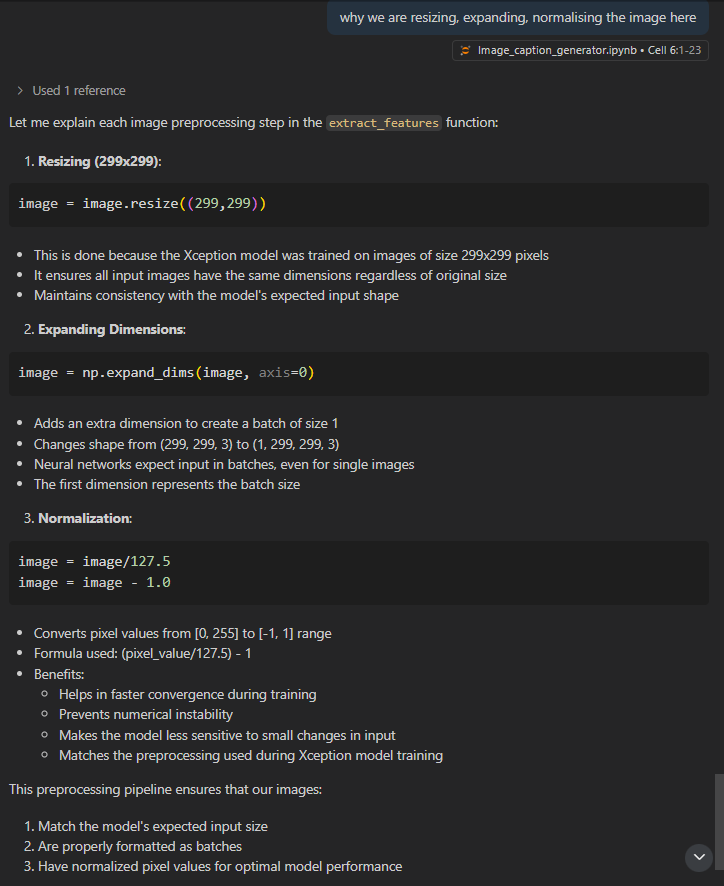

In [4]:
features = load(open("features.p", "rb")) # load the features from the file
print('Extracted Features:', len(features))

Extracted Features: 8091


In [ ]:
# we need to load the photo names from the file to match the features with the captions
def load_photos(filename): # Load the photo names from the file
    file = load_doc(filename) 
    photos = file.split('\n')[:-1] # Exclude the last empty line
    photos_present = [photo for photo in photos if os.path.exists(os.path.join(dataset_images, photo))] 
    return photos_present

In [ ]:
# Load the captions and match them with the photos
def load_clean_descriptions(filename, photos):
    file = load_doc(filename) # load the captions file
    descriptions = {}
    for line in file.split('\n'): 
        words = line.split('\t') # Split each line into words
        if len(line) < 1:
            continue
        img, img_caption = words[0], words[1] # Split each line into image name and caption
        if img in photos: 
            if img not in descriptions:
              descriptions[img] = []
            desc = '<start>' + " ".join(img_caption) + '<end>' # Add start and end tokens to the caption to help the model learn when to start and stop generating captions
            descriptions[img].append(desc) 
    return descriptions

In [ ]:
# Load the features for the given photos
def load_features(photos):
    all_features = load(open("features.p", "rb"))
    features = {k: all_features[k] for k in photos}
    # print(features)
    return features

In [ ]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions(dataset_text + "/descriptions.txt", train_imgs) # Load the captions for the training images and match them with the photos
train_features = load_features(train_imgs) # Load the features for the training images and match them with the photos
print('Training images:', len(train_imgs))
print('Training descriptions:', len(train_descriptions))
print('Training features:', len(train_features))

In [25]:
# in this cell we will create a tokenizer from the descriptions
def dict_to_list(descriptions): # Convert the dictionary of descriptions to a list because the tokenizer expects a list of strings
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions): # Create a tokenizer from the descriptions
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

Vocabulary Size: 29


In [26]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(train_descriptions)
print(max_length)

155


In [27]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length):
    def generator():
        while True:
            for key, description_list in descriptions.items():
                feature = features[key][0]
                input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
                for i in range(len(input_image)):
                    yield {'input_1': input_image[i], 'input_2': input_sequence[i]}, output_word[i]
    
    # Define the output signature for the generator
    output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
            'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )
    
    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    return dataset.batch(32)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
dataset = data_generator(train_descriptions, features, tokenizer, max_length)
for (a, b) in dataset.take(1):
    print(a['input_1'].shape, a['input_2'].shape, b.shape)
    break

(32, 2048) (32, 155) (32, 29)


In [ ]:

from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 1

# Function to calculate steps per epoch based on the number of sequences
# This function ensures that the number of steps is at least 1, even if the total sequences are less than the batch size
def get_steps_per_epoch(train_descriptions):
    total_sequences = 0
    for img_captions in train_descriptions.values():
        for caption in img_captions:
            words = caption.split()
            total_sequences += len(words) - 1
    # Ensure at least 1 step, even if sequences < batch_size
    return max(1, total_sequences // 32)

# Update training loop
steps = get_steps_per_epoch(train_descriptions)

# making a directory models to save our models
os.mkdir("models2")
for i in range(epochs):
    dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(dataset, epochs=4, steps_per_epoch=steps, verbose=1)
    model.save("models2/model_" + str(i) + ".h5")